<a href="https://colab.research.google.com/github/sohaamir/brainslicer/blob/main/brainslicer_upscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upscaling brain images using `brainslicer` and `Real-ESGRAN`

[![GitHub Stars](https://img.shields.io/badge/brainslicer_ESGRAN-v1.0-blue?logo=github)](https://github.com/sohaamir/brainslicer)

This notebook provides an integrated workflow towards generating upscaled brain images. NIFTIs, hosted on Google Drive, are firstly sliced using `brainslicer`.

`brainslicer [-h] [--plane {axial,sagittal,coronal}] [--brightness BRIGHTNESS] [--contrast CONTRAST] [--colourmap {magma,inferno,plasma}] file_path slice_number`

For more information and usage examples, use the `-h` or `--help` flags.

The slices can then be upscaled using [`Real-ESRGAN`](https://arxiv.org/abs/2107.10833), a Generative Adversarial Network capable of recovering high resolution images from low resolution ones.

You can apply `Real-ESGRAN` to sliced images on both your Google Drive and locally on your computer.

### **Pre-requisites**

1. I would strongly advocate changing the runtime from 'CPU' to 'T4 GPU'. This significantly shorten the amount of time taken to process an image (from 2-3 minutes to a few seconds).

2. You can choose to run `brainslicer` and `Real-ESGRAN` on files that are located on your local machine, or on Google Drive, however it is easier and quicker to do the latter. You can set up your directory with the following structure:

```
brainslicer/
├── brainslices/
├── niftis/
├── Real-ESRGAN-colab/
├── weights/
└── brainslicer_upscale.ipynb
```

Please note that after generating an image, if you want to generate another, you will have to change back into the original working directory by `cd% /gdrive/MyDrive/projects/brainslicer`. This is because you are changing the location of the directory in the notebook.

## Examples of `brainslicer-ESGRAN`

<img src="https://raw.githubusercontent.com/sohaamir/brainslicer/main/assets/brainslicer_example.png" width="100%">

## 1. Install the `brainslicer` package and it's dependencies

In [ ]:
# Install brainslicer from GitHub
%%capture
!pip install git+https://github.com/sohaamir/brainslicer.git
!pip install nibabel numpy Pillow matplotlib

In [ ]:
# pass the help argument for instructions
!brainslicer --help

## 2. Change to your relevant directory and run `brainslicer`

In [ ]:
# Mount your Google Drive and change to your brainslicer directory (you will have to give permissions)
from google.colab import drive, files

drive.mount('/gdrive')
%cd /gdrive/MyDrive/projects/brainslicer

# drive.mount('/content/drive')
#%cd /content/drive/MyDrive/projects/brainslicer/

In [ ]:
# It may be useful to print out the dimensions of the NIFTI first (sagittal, coronal, axial)
import nibabel as nib

# Load the NIFTI file
nifti_file_path = 'niftis/aamir_T1.nii'
nifti_img = nib.load(nifti_file_path)

# Get dimensions of the NIFTI image
nifti_dimensions = nifti_img.header.get_data_shape()
print(nifti_dimensions)

In [15]:
# Run brainslicer using the CLI
!brainslicer niftis/aamir_T1.nii 96 --plane sagittal --brightness 1.5 --contrast 2.0 --colourmap viridis

Figure(640x480)
Image saved as 'brainslices/aamir_T1_96_sagittal_brightness_1.5_contrast_2.0_viridis.png'.


You can also choose to upload NIFTIs from your local machine, but it takes quite a while...

In [ ]:
from google.colab import files

uploaded = files.upload()

## 3. Display the sliced image

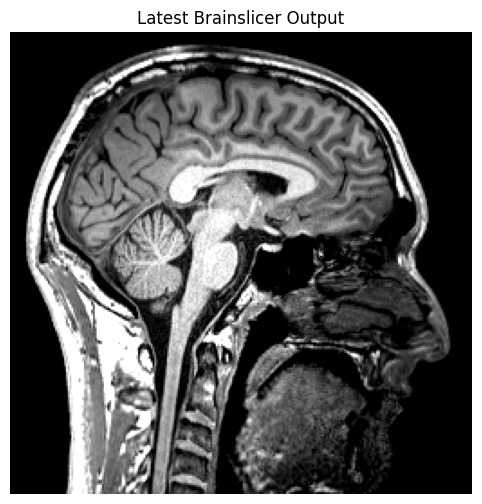

In [16]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

output_dir = '/gdrive/MyDrive/projects/brainslicer/brainslices'  # Your output directory

# Find the latest file in the output directory
latest_file = None
latest_timestamp = 0

for filename in os.listdir(output_dir):
    if filename.endswith('.png'):
        filepath = os.path.join(output_dir, filename)
        file_timestamp = os.path.getmtime(filepath)  # Get file modification timestamp
        if file_timestamp > latest_timestamp:
            latest_timestamp = file_timestamp
            latest_file = filepath

# Check if an image was found
if latest_file:
    img = mpimg.imread(latest_file)

    # Display the image
    plt.figure(figsize=(8,6))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Latest Brainslicer Output')
    plt.show()
else:
    print("No image found in the 'brainslices' directory.")

## 4. Setup the Real-ESGRAN environment

In [ ]:
# Clone Real-ESRGAN and install requirements
%%capture
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git
!git clone https://github.com/boomb0om/Real-ESRGAN-colab
%cd Real-ESRGAN-colab
!pip install -r requirements.txt

## 5. Set up the model using the heaviest weights, and create a function which displays the original and upscaled slice side-by-side

In [18]:
import torch
from PIL import Image
import numpy as np
from RealESRGAN import RealESRGAN

# Set up the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealESRGAN(device, scale=4)
model.load_weights('/content/drive/MyDrive/projects/brainslicer/weights/RealESRGAN_x4.pth')

def upscale_image(image_path, output_dir):
    """Upscales a single image and saves the result."""
    image = Image.open(image_path).convert('RGB')
    sr_image = model.predict(image)

    # Create output directory if needed
    os.makedirs(output_dir, exist_ok=True)

    # Save images
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    image.save(os.path.join(output_dir, f'{base_filename}_original.png'))
    sr_image.save(os.path.join(output_dir, f'{base_filename}_upscaled.png'))

    # Display images side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(sr_image)
    ax2.set_title('Upscaled Image')
    ax2.axis('off')
    plt.show()

## 6. Run the model on your sliced image

You need to select the directory in which the slices are in. Usually, this will be the 'brainslices' subdirectory, as this is automatically created by `brainslicer` when it is run.

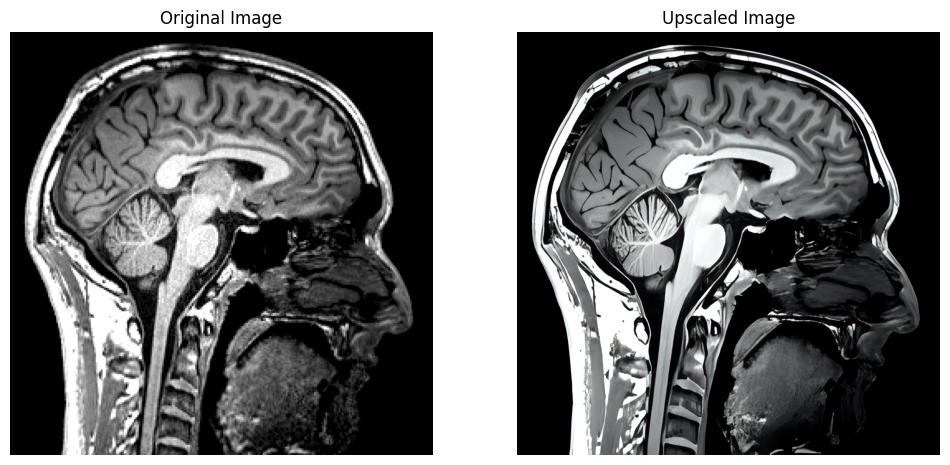

In [19]:
# Find the most recently modified file with a .png extension
most_recent_file = None
most_recent_timestamp = 0

pictures_dir = '/gdrive/MyDrive/projects/brainslicer/brainslices'

for filename in os.listdir(pictures_dir):
    if filename.endswith('.png'):
        filepath = os.path.join(pictures_dir, filename)
        file_timestamp = os.path.getmtime(filepath)
        if file_timestamp > most_recent_timestamp:
            most_recent_timestamp = file_timestamp
            most_recent_file = filepath

if most_recent_file:
    upscale_image(most_recent_file, output_dir)
else:
    print("No PNG files found in the directory.")

Again, you can choose to upload your slices if you wish.

In [ ]:
uploaded = files.upload()
for filename in uploaded.keys():
  output_dir = 'brainslicer_upscaled'
  upscale_image(filename, output_dir)